In [2]:
############################################
#FEATURE ENGINEERIN ON DIABETES DATASET
############################################


##Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Content
Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Pregnancies: Number of times pregnant
Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
BloodPressure: Diastolic blood pressure (mm Hg)
SkinThickness: Triceps skin fold thickness (mm)
Insulin: 2-Hour serum insulin (mu U/ml)
BMI: Body mass index (weight in kg/(height in m)^2)
DiabetesPedigreeFunction: Diabetes pedigree function
Age: Age (years)
Outcome: Class variable (0 or 1) 0= Negative 1= positive
Sources:
(a) Original owners: National Institute of Diabetes and Digestive and
Kidney Diseases
(b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)
Research Center, RMI Group Leader
Applied Physics Laboratory
The Johns Hopkins University
Johns Hopkins Road


In [3]:
# Libraries and Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [4]:
##################################
# TASK 1 # INITIAL ANALYSIS
##################################
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [5]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                    

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
#################################################
# IDENTIFYING NUMERICAL AND CATEGORICAL VARIABLES
#################################################
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [9]:
cat_cols

['Outcome']

In [10]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [11]:
cat_but_car

[]

In [12]:
##################################
# CATEGORICAL VARIABLE ANALYSIS
##################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


cat_summary(df, "Outcome")


   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################


count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


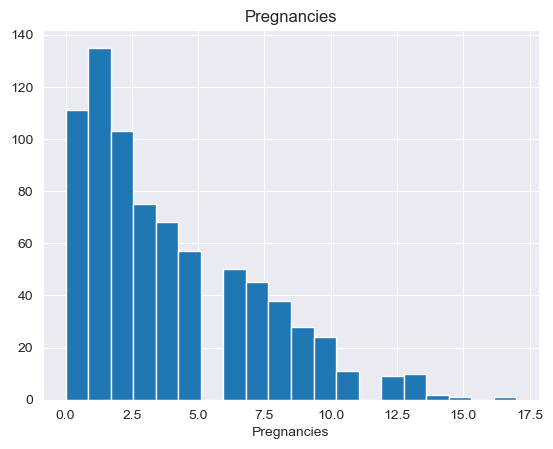

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


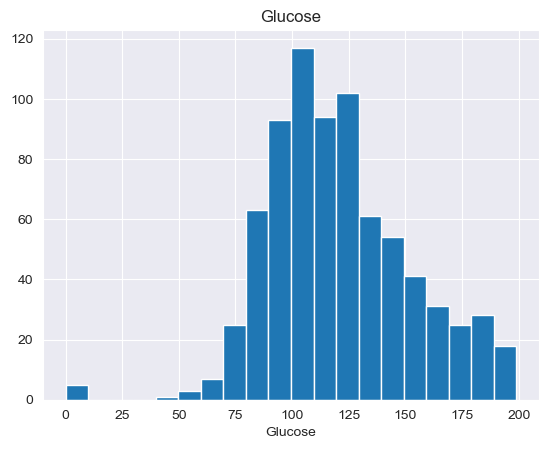

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


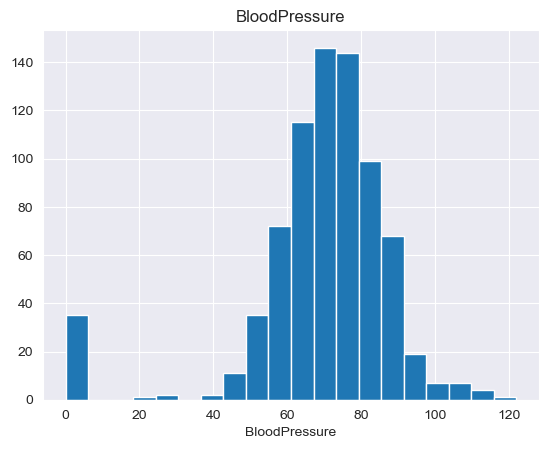

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


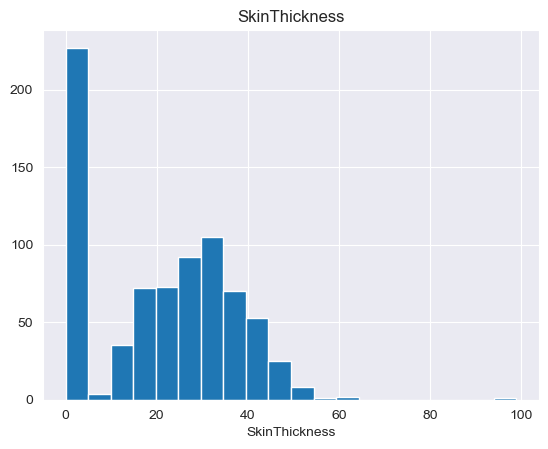

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


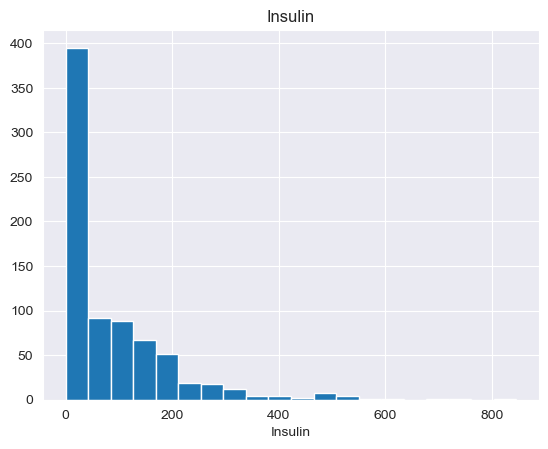

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


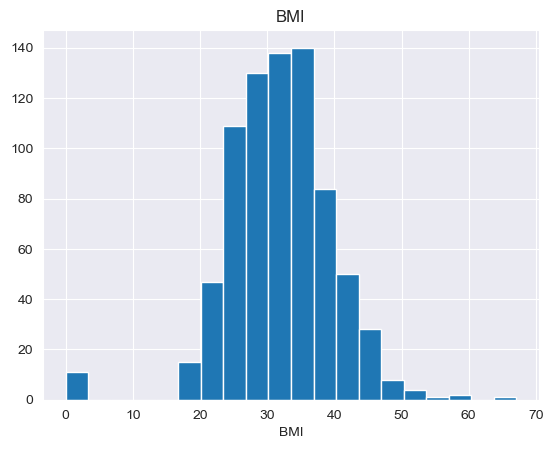

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


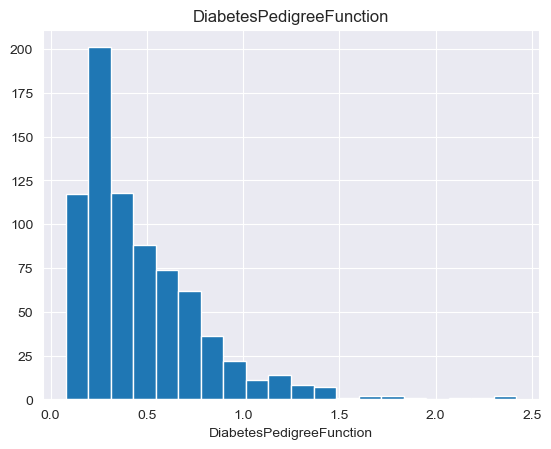

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


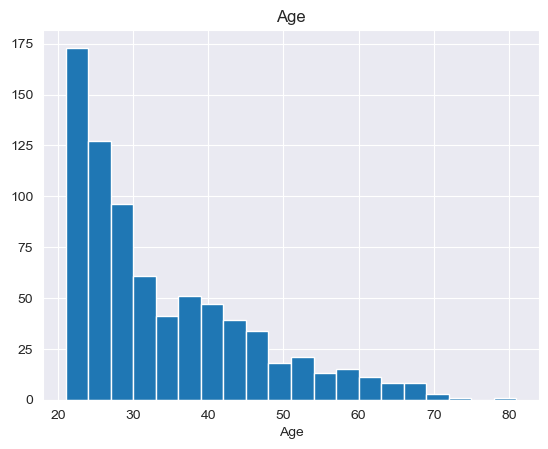

In [13]:
##################################
# NUMERICAL VARIABLE ANALYSIS
##################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


for col in num_cols:
    num_summary(df, col, plot=True)

In [14]:
###########################################
# ANALYSIS OF TARGET WITH NUMERIC VARIABLES
###########################################

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [15]:
###############################################
# ANALYSIS OF TARGET WITH CATEGORICAL VARIABLES
###############################################


def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col)

Outcome
   TARGET_MEAN  Count  Ratio
0        0.000    500 65.104
1        1.000    268 34.896




In [ ]:
##################################
# ANALYSIS OF CORRELATION
##################################

In [14]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


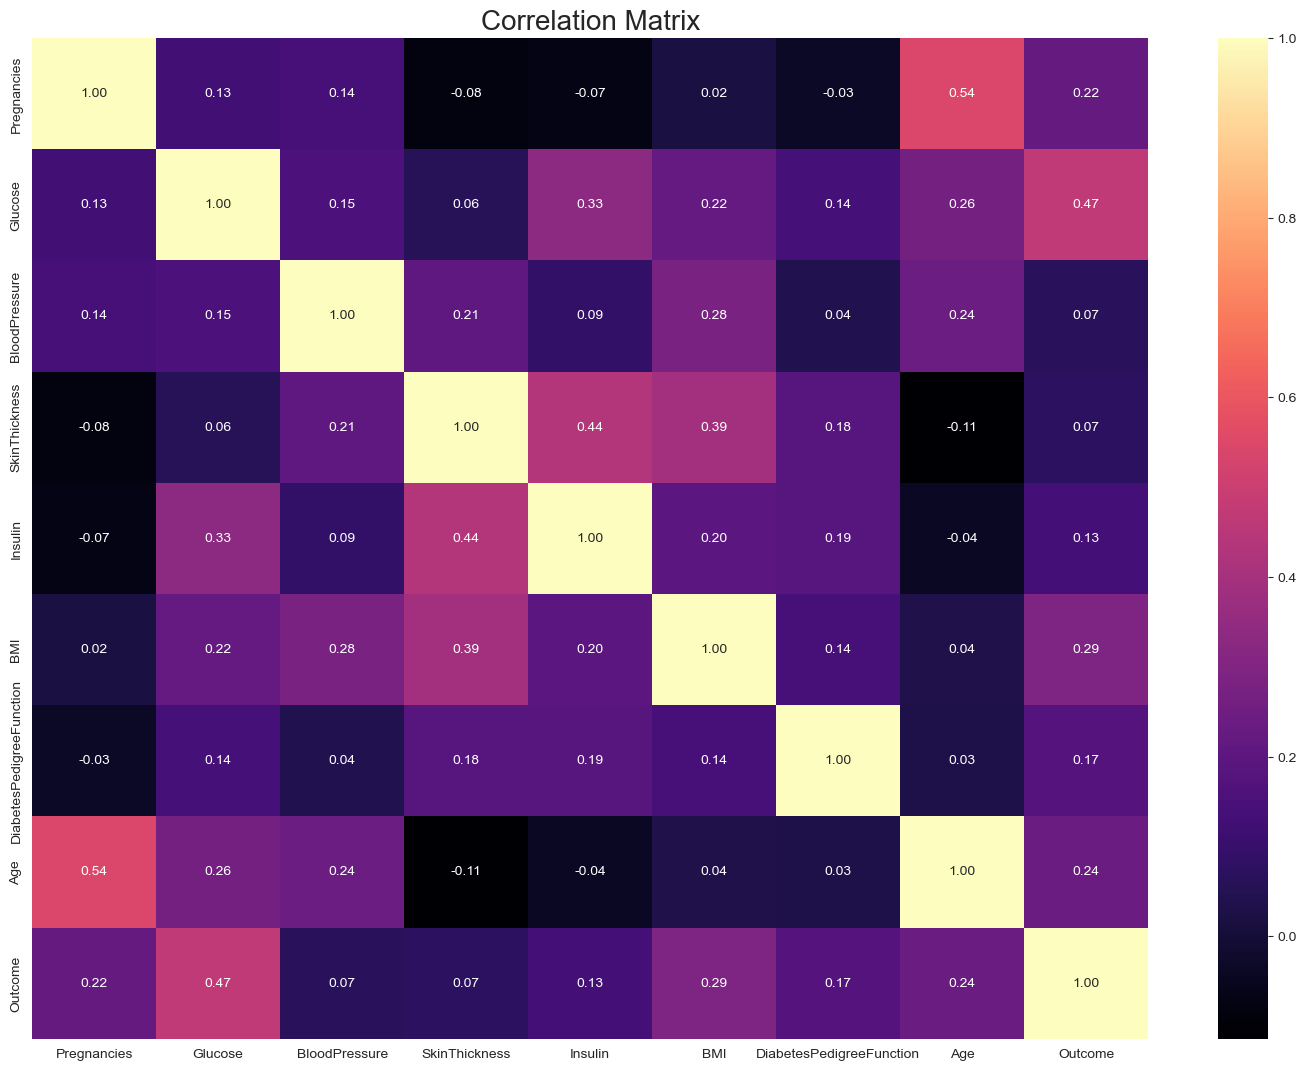

In [15]:
# CORRELATION MATRIX
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [16]:
df.corrwith(df["Outcome"]).sort_values(ascending=False)

Outcome                    1.000
Glucose                    0.467
BMI                        0.293
Age                        0.238
Pregnancies                0.222
DiabetesPedigreeFunction   0.174
Insulin                    0.131
SkinThickness              0.075
BloodPressure              0.065
dtype: float64

In [ ]:
####################################
# BASE MODELLING WITH RANDOM FOREST
####################################

In [16]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


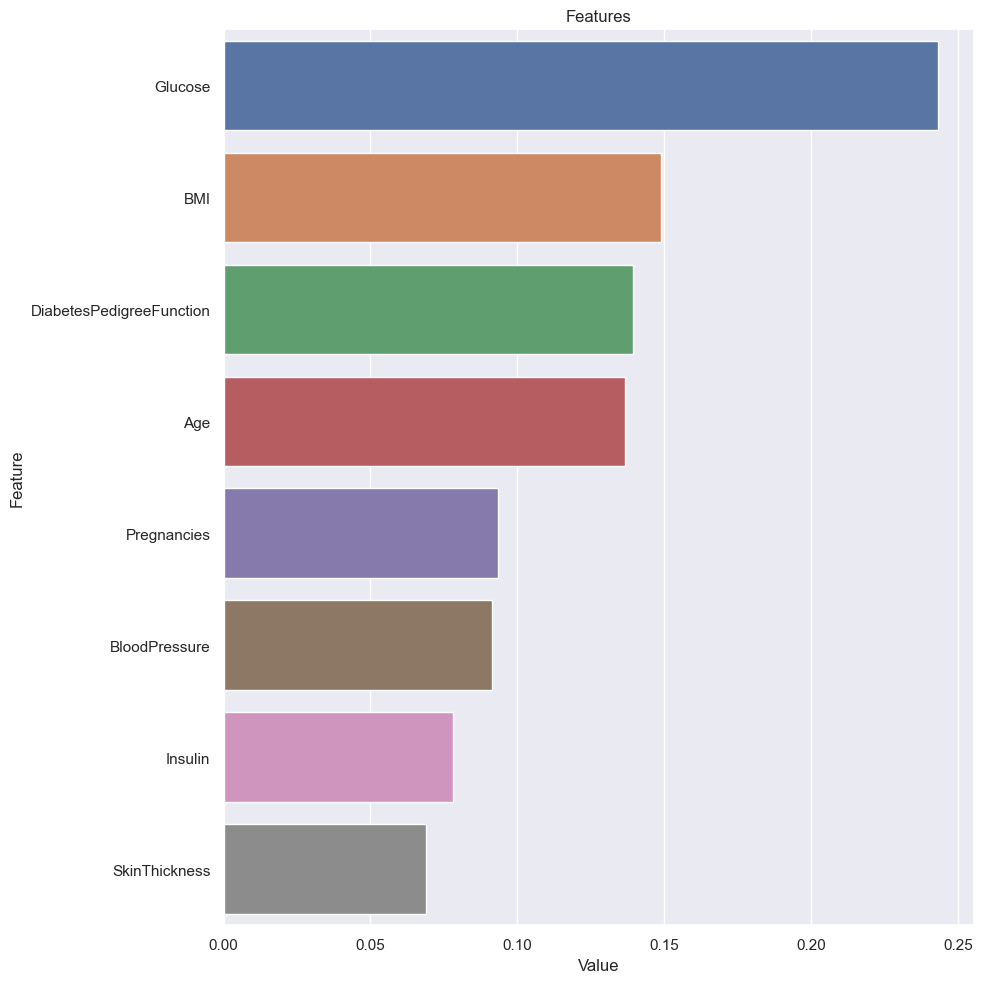

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X)

In [18]:
##################################
# TASK 2: FEATURE ENGINEERING
##################################

In [ ]:
##################################
# MISSING VALUE ANALYSIS
##################################

In [19]:
# Pregnancies and Outcome variable are the only ones may indicate 0 as observation.
# Other variable having observations as "0" is a misleading info . We may replace them with "Nan"
# Let's identify them as zero columns
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [20]:
# Let's replace zero "0" values with "Nan"
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [21]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [22]:
##################################
# MISSING VALUES
##################################
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [23]:
# ANALYSIS OF MISSING VALUES WITH TARGET
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [24]:
missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [25]:
# FILLING MISSING VALUES WITH MEDIAN,
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [26]:
#########################################################
# Detection of outliers and replacing them with threshold
#########################################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


# Replacing with threshold
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [27]:
##################################
# FEATURE EXTRACTION
##################################

#  Creating new categorical variable from "Age"
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

# From the variable "BMI",
# it is possible to create new variables as :"Underweight", "Healthy", "Overweight", "Obese"
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])

# Creation of new variable called NEW_GLUCOSE
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

#  Creation of new categorical variable with Age and BMI
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

# Creation of new categorical variable with Age and Glucose
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"


# Creation of new categorical variable with "Insulin" value
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"


df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

# NEW_GLUCOSE*PREGNANCIES, if necessary add +1
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]
# df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * (1+ df["Pregnancies"])


# CAPITALIZE COL NAMES
df.columns = [col.upper() for col in df.columns]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


In [28]:
##################################
# ENCODING
##################################

# IDENTIFYNG LATEST COL NAMES
cat_cols, num_cols, cat_but_car = grab_col_names(df)


# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    df = label_encoder(df, col)

# One-Hot Encoding
# cat_cols UPDATING
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,85.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1464.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [29]:
##################################
# BASE MODELLING
##################################

y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


    Value                            Feature
1   0.138                            GLUCOSE
10  0.131                NEW_GLUCOSE*INSULIN
5   0.099                                BMI
11  0.098            NEW_GLUCOSE*PREGNANCIES
7   0.097                                AGE
..    ...                                ...
20  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
17  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
13  0.000  NEW_AGE_BMI_NOM_underweightmature
18  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
25  0.000               NEW_GLUCOSE_Diabetes

[26 rows x 2 columns]


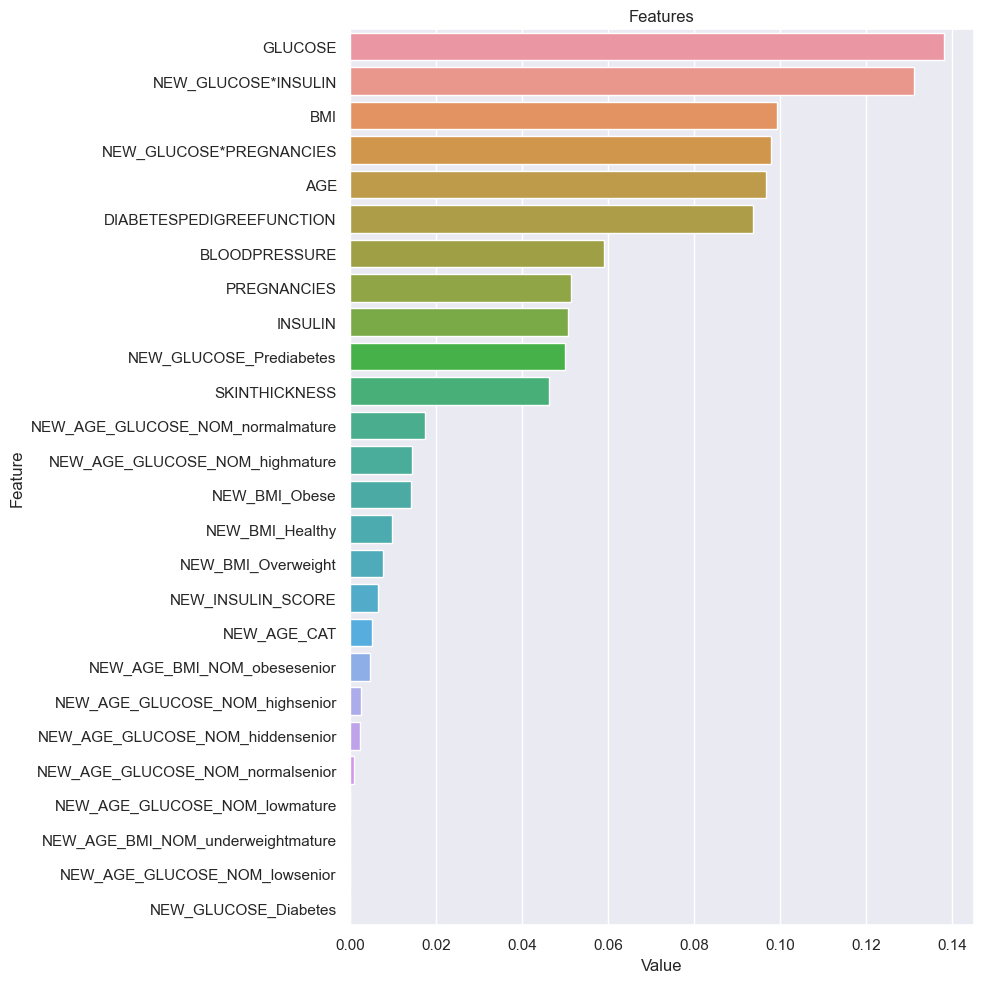

In [30]:
##################################
# FEATURE IMPORTANCE
##################################

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value", ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X)
